# Time series
## Temperature prediction

In [29]:
with open('jena_climate_2009_2016.csv') as file:
    data = file.read()
len(data)

43153572

In [30]:
data[:300]

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"\n01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30\n01'

In [31]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [32]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    temp = [float(x) for x in line.split(',')[1:]]
    temperature[i] = temp[1]
    raw_data[i,:] = temp[:]

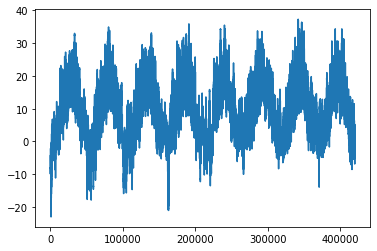

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)), temperature)

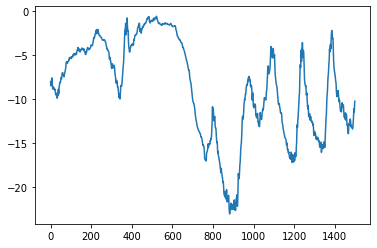

In [34]:
plt.plot(range(1500), temperature[:1500])

In [38]:
n_train = int(0.5*len(lines))
n_val = int(0.25*len(lines))
n_test = len(lines) - n_train -n_val
n_train, n_val, len(lines), n_test+ n_val+n_train

(210225, 105112, 420451, 420451)

Preparing the data

In [40]:
import numpy as np

mean = raw_data[:n_train].mean(axis=0)
std = raw_data[:n_train].std(axis=0)
raw_data = (raw_data-mean) / std

Dataset creating

In [47]:
# Example

from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length=3,
    batch_size=2
)

for input, target in dummy_dataset:
    for i in range(input.shape[0]):
        print([int(x) for x in input[i]], int(target[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [51]:
sampling_rate = 6 #Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
sequence_length = 120 #Observations will go back 5 days (120 hours).
delay = sampling_rate * (sequence_length + 24 - 1) #The target for a sequence will be the temperature 24 hours after the end of the sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=n_train
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train,
    end_index=n_train + n_val
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train + n_val,
    )


Naive approach: temperature after 24 hour will be like now

In [52]:
def evaluate_naive_methof(dataset):
    total_abs_error = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] +mean[1]
        total_abs_error += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_error / samples_seen

print('Train MAE: ', evaluate_naive_methof(train_dataset))
print('Test MAE: ', evaluate_naive_methof(test_dataset))

Train MAE:  2.691671264784777
Test MAE:  2.6218984517612043


Model

In [53]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 9s 10ms/step - loss: 15.3930 - mae: 3.0259 - val_loss: 15.5250 - val_mae: 3.1522
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 10.3544 - mae: 2.5303 - val_loss: 11.8605 - val_mae: 2.7245
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 9.3932 - mae: 2.4102 - val_loss: 11.4215 - val_mae: 2.6907
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 8.6617 - mae: 2.3142 - val_loss: 13.5076 - val_mae: 2.9356
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 8.2431 - mae: 2.2570 - val_loss: 11.0422 - val_mae: 2.6467
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 7.9386 - mae: 2.2157 - val_loss: 12.1226 - val_mae: 2.7734
Epoch 7/10
819/819 [==============================] - 8s 9ms/step - loss: 7.6913 - mae: 2.1814 - val_loss: 10.9043 - val_mae: 2.6218
Epoch 8/10
819/819 [==============================] - 8s 10ms

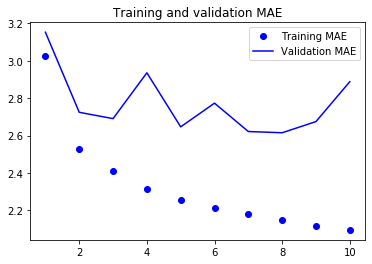

In [55]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

1D convolutional

In [56]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 97, 8)             2696      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 8)             776       
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________

In [57]:
callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras",save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 25ms/step - loss: 23.6145 - mae: 3.8365 - val_loss: 19.2175 - val_mae: 3.3854
Epoch 2/10
819/819 [==============================] - 21s 26ms/step - loss: 17.9439 - mae: 3.3592 - val_loss: 16.0749 - val_mae: 3.1369
Epoch 3/10
819/819 [==============================] - 21s 26ms/step - loss: 16.2648 - mae: 3.1984 - val_loss: 16.3015 - val_mae: 3.1354
Epoch 4/10
819/819 [==============================] - 22s 26ms/step - loss: 15.3205 - mae: 3.1096 - val_loss: 16.1752 - val_mae: 3.1468
Epoch 5/10
819/819 [==============================] - 21s 25ms/step - loss: 14.5781 - mae: 3.0382 - val_loss: 14.6178 - val_mae: 3.0168
Epoch 6/10
819/819 [==============================] - 23s 28ms/step - loss: 14.1252 - mae: 2.9927 - val_loss: 14.2270 - val_mae: 2.9681
Epoch 7/10
819/819 [==============================] - 26s 32ms/step - loss: 13.7900 - mae: 2.9603 - val_loss: 13.9169 - val_mae: 2.9387
Epoch 8/10
819/819 [============================

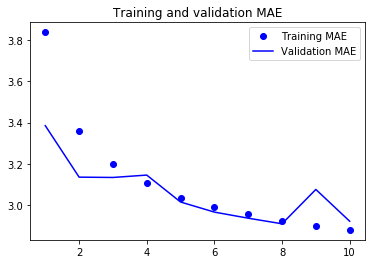

In [58]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

Reccurent model

In [59]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1984      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [60]:
callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras",save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 59ms/step - loss: 38.6578 - mae: 4.5407 - val_loss: 12.1077 - val_mae: 2.6670
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 11.0055 - mae: 2.5854 - val_loss: 10.2286 - val_mae: 2.4839
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 9.8503 - mae: 2.4547 - val_loss: 9.6946 - val_mae: 2.4139
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 9.4338 - mae: 2.4012 - val_loss: 10.0958 - val_mae: 2.4504
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 9.1649 - mae: 2.3654 - val_loss: 10.0905 - val_mae: 2.4265
Epoch 6/10
819/819 [==============================] - 42s 52ms/step - loss: 8.9276 - mae: 2.3315 - val_loss: 11.1297 - val_mae: 2.5033
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 8.7108 - mae: 2.2995 - val_loss: 9.9512 - val_mae: 2.4420
Epoch 8/10
819/819 [==============================] - 4

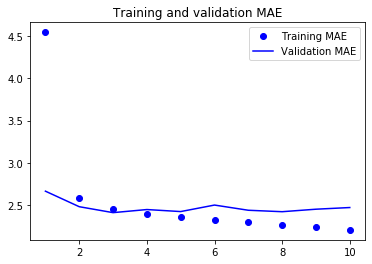

In [61]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()